<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discovery-of-pivotal-data-instances-using-vertex-energy-and-data-similarity-graph" data-toc-modified-id="Discovery-of-pivotal-data-instances-using-vertex-energy-and-data-similarity-graph-1">Discovery of pivotal data instances using vertex energy and data similarity graph</a></span><ul class="toc-item"><li><span><a href="#Graph-energy" data-toc-modified-id="Graph-energy-1.1">Graph energy</a></span></li><li><span><a href="#Randić-energy" data-toc-modified-id="Randić-energy-1.2">Randić energy</a></span></li><li><span><a href="#Laplacian-energy" data-toc-modified-id="Laplacian-energy-1.3">Laplacian energy</a></span></li><li><span><a href="#Matrix-energies-for-various-topologies-of-small-egocentric-networks" data-toc-modified-id="Matrix-energies-for-various-topologies-of-small-egocentric-networks-1.4">Matrix energies for various topologies of small egocentric networks</a></span></li></ul></li><li><span><a href="#Correlation-of-graph/Randić/Laplacian-energy-and-betweenness-in-data-similarity-graph" data-toc-modified-id="Correlation-of-graph/Randić/Laplacian-energy-and-betweenness-in-data-similarity-graph-2">Correlation of graph/Randić/Laplacian energy and betweenness in data similarity graph</a></span></li></ul></div>

In [1]:
import sys
sys.path.append("..")
sys.path.append("...")

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import logging
import requests
import itertools

import network_energy as ne

from functools import partial

from data2graph.measures import measure, caterogical, numerical
from data2graph.measures.measure import Measure
from data2graph.network.network import Network
from data2graph.network.weight import Weight
from data2graph.network import network, load, weight, algorithm

from data2graph.datasets import loader

# Discovery of pivotal data instances using vertex energy and data similarity graph

In this experiment we verify the usefulness of the concept of graph energy in discovering pivotal data points.
We transform relational dataset into graph representation where each data instance is represented by a single vertex
and an edge exists between vertices if the similarity between data instances exceeds a given threshold.

We use this data similarity graph to estimate the relative importance of data instances. An instance is important
if its characterized by high betweenness in data similarity graph. Unfortunately, exact computation of betweenness 
for large graphs is prohibitively expensive. We present a simple method which allows to estimate the betweenness
of vertices with high precision using a novel concept of vertex energy.

## Graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).

## Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

## Laplacian energy

Laplacian matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_L(i,j)=
\begin{cases}
d_i & \mathit{if} & i=j\\
-1 & \mathit{if} & (i,j) \in E\\
0 & \mathit{otherwise}
\end{cases}
$$

Laplacian energy of a graph is defined as $E_L(G) =  \sum\limits_{i=1}^n |\lambda_i - \frac{2m}{n}|$, where $\lambda_1, \ldots, \lambda_n$ are the eigenvalues of the Laplacian matrix $M_L$, $n$ is the number of vertices and $m$ is the number of edges in the graph $G$.

In [2]:
def chunks(lst, n):
    """
    Divide a list of vertices `lst` into chunks consisting of `n` vertices
    
    Tests:
    >>> list(chunks([1,2,3,4,5,6], 2))
    [(1, 2), (3, 4), (5, 6)]

    >>> list(chunks([1,2,3,4,5,6], 4))
    [(1, 2, 3, 4), (5, 6)]

    >>> list(chunks([], 2))
    []

    """
    _lst = iter(lst)
    while 1:
        x = tuple(itertools.islice(_lst, n))
        if not x:
            return
        yield x
        
def normalize_df_column(df_column):
    """
    Normalize a dataframe column to the range [0,1]
    
    Tests:
    >>> normalize_df_column(pd.Series([1,2,3,4,5]))
    array([[0.  ],
           [0.25],
           [0.5 ],
           [0.75],
           [1.  ]])
    """
    x = df_column.values.astype(float)
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    
    return x_scaled

In [3]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=4)

## Matrix energies for various topologies of small egocentric networks

Firstly, let us examine the relationship between the topology of a small egocentric network and its energies. We generate five different egocentric networks representing possible small scale configurations and compute all three types of matrix energies. The results are somehow surprising, graph energy tends to correlate with the degree of connectivity of the egocentric network, Randic energy remains practically constant, and Laplacian energy behaves unpredictably, receiving the maximum value for a custom topology. 

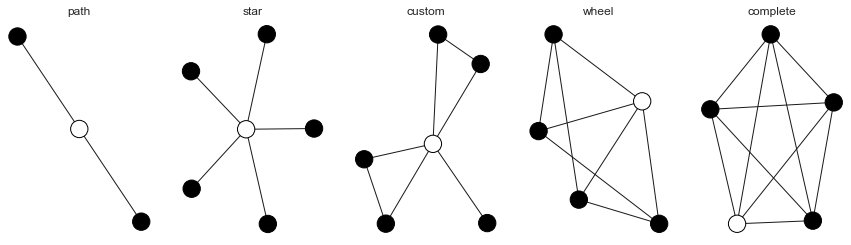

       name  graph energy  randic energy  laplacian energy
0      path      2.828427       2.000000          3.333333
1      star      4.472136       2.000000          8.666667
2    custom      7.806424       3.306226         10.000000
3     wheel      6.472136       2.000000          7.200000
4  complete      8.000000       2.000000          8.000000


In [4]:
g_custom = nx.star_graph(n=5)
g_custom.add_edge(1,2)
g_custom.add_edge(4,5)

graphs = [
    {'name': 'path', 'graph': nx.path_graph(n=3)},
    {'name': 'star', 'graph': nx.star_graph(n=5)},
    {'name': 'custom', 'graph': g_custom},
    {'name': 'wheel', 'graph': nx.wheel_graph(n=5)},
    {'name': 'complete', 'graph': nx.complete_graph(n=5)}
]

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set(rc={'figure.figsize': (15, 4)})
fig, ax = plt.subplots(5, 1)

df = pd.DataFrame(
    {'name': [ g['name'] for g in graphs],
     'graph energy': [ne.get_graph_energy(g['graph']) for g in graphs],
     'randic energy': [ne.get_randic_energy(g['graph']) for g in graphs],
     'laplacian energy': [ne.get_laplacian_energy(g['graph']) for g in graphs]
    }
)

plt.subplot(151)
nx.draw(graphs[0]['graph'], node_color=['black','white','black'], edgecolors='black')
plt.title(graphs[0]['name'])

plt.subplot(152)
nx.draw(graphs[1]['graph'], node_color=['white','black', 'black', 'black', 'black', 'black'], edgecolors='black')
plt.title(graphs[1]['name'])

plt.subplot(153)
nx.draw(graphs[2]['graph'], node_color=['white','black','black', 'black', 'black', 'black'], edgecolors='black')
plt.title(graphs[2]['name'])

plt.subplot(154)
nx.draw(graphs[3]['graph'], node_color=['white','black','black', 'black', 'black'], edgecolors='black')
plt.title(graphs[3]['name'])

plt.subplot(155)
nx.draw(graphs[4]['graph'], node_color=['white','black','black', 'black', 'black'], edgecolors='black')
plt.title(graphs[4]['name'])

plt.show()

print(df[['name', 'graph energy', 'randic energy', 'laplacian energy']])

Next, we start with a star configuration of an egocentric network consisting of an ego and additional $n$ vertices, 
and we gradually add all remaining edges, until we form a full $K_5$ graph. 
For each intermediate graph we compute all its energies. We can clearly see that each of matrix energies 
is measuring a different "aspect" of the egocentric network:

* randic energy is maximized for topologies very close to the original star-like structure and diminishes as more and more edges are added to the egocentric network
* laplacian energy strongly resembles the entropy of adjacency matrix, being maximized half-way between the star structure and the clique structure of the egocentric network
* graph energy steadily grows as the density of the egocentric network increases.

In [5]:
from itertools import combinations
from random import shuffle

g = nx.star_graph(n=25)

results = []

edges = list(combinations(range(1, len(g.nodes)), r=2))

# comment if you want to add edges in an ordered way
shuffle(edges)

for (idx, (i, j)) in enumerate(edges):
    results.append((idx, ne.get_graph_energy(g), ne.get_randic_energy(g),
                    ne.get_laplacian_energy(g)))

    g.add_edge(i, j)

In [6]:
df = pd.DataFrame(
    data=results,
    columns=[
        'complexity', 'graph energy', 'randic energy', 'laplacian energy'
    ])

dfn = df[['graph energy','randic energy','laplacian energy']].apply(lambda s: s/s.max(), axis=0)
dfn['complexity'] = df['complexity']

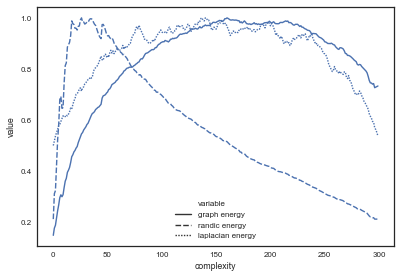

In [7]:
dfm = pd.melt(
    dfn,
    value_vars=['graph energy', 'randic energy', 'laplacian energy'],
    id_vars='complexity')

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.lineplot(data=dfm, x='complexity', y='value', style='variable')

# Correlation of graph/Randić/Laplacian energy and betweenness in data similarity graph

In this experiment we create data similarity graphs for a few well-known datasets. 
For each graph we collect detailed statistics on every vertex:

- its betweenness,
- its Randić energy,
- its Laplacian energy,
- and its graph energy.

We normalize these variables using MinMax scaling to the range of [0-1]. 

Finally, we compute the correlation between vertex betweenness and vertex energies.

In [8]:
datasets = {
    'inflammation': loader.load_diagnosis_inflammation,
    'diagnosis_nephritis': loader.load_diagnosis_nephritis,
    'iris': loader.load_iris,
    'titanic': loader.load_titanic,
    'lenses': loader.load_lenses,
    'mushrooms': loader.load_mushrooms,
    'breast_cancer': loader.load_breast_cancer_short,
    'wine_quality': loader.load_wine_quality_classification,
    'pima_diabetes': loader.load_pima_diabetes,
    'internet_ads': loader.load_internet_ads_pca,
    'housing_prices': loader.load_housing_prices_short,
    'ionosphere': loader.load_ionosphere,
    'monks1': loader.load_monks_1,
    'monks2': loader.load_monks_2,
    'monks3': loader.load_monks_3,
    'yeast': loader.load_yeast,
    'heart_statlog': loader.load_heart_statlog,
    'haberman': loader.load_haberman,
    'hepatitis': loader.load_hepatitis,
    'dermatology': loader.load_dermatology,
    'glass': loader.load_glass,
    'ecoli': loader.load_ecoli,
    'cmc': loader.load_cmc,
    'zoo': loader.load_zoo,
    'balance_scale': loader.load_balance_scale,
    'segmentation': loader.load_segmentation,
    'car': loader.load_car,
    'house_voting': loader.load_house_voting
}

In [10]:
for d in datasets:
    X, y, types = datasets[d]()
    print(f'{d}: {len(X)} rows')

inflammation: 120 rows
diagnosis_nephritis: 120 rows
iris: 150 rows
titanic: 1043 rows
lenses: 24 rows
mushrooms: 8124 rows
breast_cancer: 569 rows
wine_quality: 1599 rows
pima_diabetes: 768 rows
internet_ads: 2359 rows
housing_prices: 8059 rows
ionosphere: 351 rows
monks1: 556 rows
monks2: 601 rows
monks3: 554 rows
yeast: 1484 rows
heart_statlog: 303 rows
haberman: 306 rows
hepatitis: 142 rows
dermatology: 358 rows
glass: 214 rows
ecoli: 336 rows
cmc: 1473 rows
zoo: 101 rows
balance_scale: 625 rows
segmentation: 210 rows
car: 1728 rows
house_voting: 435 rows


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def _compute_difference_clustering_scores(X, betweenness, n_clusters, top_k=3):
    
    model = KMeans(n_clusters=n_clusters).fit(X)

    original_silhouette_score = silhouette_score(X, model.labels_)
    original_davies_bouldin_score = davies_bouldin_score(X, model.labels_)

    without_top_betweenness_idx = [ 
        idx
        for idx, val
        in sorted(betweenness, key=lambda x: x[1])[:-top_k]
    ]

    X_lim = X[without_top_betweenness_idx]

    model = KMeans(n_clusters=n_clusters).fit(X_lim)

    reduced_silhouette_score = silhouette_score(X_lim, model.labels_)
    reduced_davies_bouldin_score = davies_bouldin_score(X_lim, model.labels_)

    delta_silhouette_score = reduced_silhouette_score - original_silhouette_score # larger values are better
    delta_davies_bouldin_score = original_davies_bouldin_score - reduced_davies_bouldin_score # lower values are better
    
    return delta_silhouette_score/original_silhouette_score, delta_davies_bouldin_score/original_davies_bouldin_score

In [22]:
def _find_optimum_number_clusters(X):
    
    scores = list()
    
    for k in range(2, int(np.sqrt(len(X)))):
        
        model = KMeans(n_clusters=k).fit(X)
        score = silhouette_score(X, model.labels_)
        
        scores.append(score)
        
    return np.argmax(scores)+2

In [32]:
results = pd.DataFrame(columns=[
    'dataset',
    'nodes',
    'betweenness',
    'randic_energy',
    'graph_energy',
    'network_model',
    'network_model_param',
    'silhouette_diff',
    'davies_bouldin_diff',
    'top_k'
])

# TODO: repeat experiment for another size of neighborhood
radius = 1

for dataset in tqdm(datasets):

    X, y, types = datasets[dataset]()
    
#     if len(X) > 500:
#         continue

    measure_strategy = measure.Measure(numerical_strategy=numerical.manhattan,
                                       categorical_strategy=caterogical.overlap)

    measures = measure_strategy.compute(X, types)

    network_strategy = network.Network(load_strategy=partial(load.load_graph_weight_distance),
                                       weight_strategy=algorithm.weight_by_degree)

    G = network_strategy.load(measures, y)

    be = nx.betweenness_centrality(G, k=None, normalized=True)
    re = ne.randic_centrality(G, radius=radius, normalized=True)
    ge = ne.graph_energy_centrality(G, radius=radius, normalized=True)
    le = ne.laplacian_centrality(G, radius=radius, normalized=True)

    n_clusters = _find_optimum_number_clusters(X)
    
    print(f'Dataset {dataset}: number of clusters: {n_clusters}')
    
    for top_k in [1, 2, 3, 5, 10, 15, 20]:
        silhouette_diff, davies_bouldin_diff = _compute_difference_clustering_scores(
            X, be.items(), n_clusters=n_clusters, top_k=top_k)

        _dict = {
            'dataset': dataset,
            'nodes': list(G.nodes),
            'betweenness': list(be.values()),
            'randic_energy': list(re.values()),
            'graph_energy': list(ge.values()),
            'laplacian_energy': list(le.values()),
            'silhouette_diff': silhouette_diff,
            'davies_bouldin_diff': davies_bouldin_diff,
            'top_k': top_k
        }

        _result = pd.DataFrame.from_dict(_dict)

        results = pd.concat([results, _result], axis=0)

Dataset inflammation: number of clusters: 2
Dataset diagnosis_nephritis: number of clusters: 2
Dataset iris: number of clusters: 2
Dataset titanic: number of clusters: 2
Dataset lenses: number of clusters: 2


KeyboardInterrupt: 

In [ ]:
results.groupby('top_k')[['silhouette_diff','davies_bouldin_diff']].describe()

In [55]:
results[[
    'betweenness', 
    'randic_energy',
    'graph_energy',
    'laplacian_energy']].describe().round(4)

,betweenness,randic_energy,graph_energy,laplacian_energy
count,214.0000,214.0000,214.0000,214.0000
mean,0.0038,0.0047,0.0047,0.0047
std,0.0089,0.0027,0.0059,0.0068
min,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0035,0.0002,0.0000
50%,0.0008,0.0049,0.0010,0.0003
75%,0.0031,0.0069,0.0092,0.0095
max,0.0811,0.0099,0.0200,0.0215


In [56]:
# what is the correlation between betweenness and randić energy for different models?
_results = results.groupby(
    ['dataset'])[[
        'betweenness',
        'randic_energy', 
        'graph_energy',
        'laplacian_energy']].corr(method='spearman').reset_index()

_results[['level_1', 'betweenness']]

,level_1,betweenness
0,betweenness,1.000000
1,randic_energy,0.875961
2,graph_energy,0.775190
3,laplacian_energy,0.750287


In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

top_k = 3

def _compute_difference(X, n_clusters, top_k=3):
    
    model = KMeans(n_clusters=3).fit(X)

    original_silhouette_score = silhouette_score(X, model.labels_)
    original_davies_bouldin_score = davies_bouldin_score(X, model.labels_)

    without_top_betweenness_idx = [ 
        idx
        for idx, val
        in sorted(be.items(), key=lambda x: x[1])[:-top_k]
    ]

    X_lim = X[without_top_betweenness_idx]

    model = KMeans(n_clusters=3).fit(X_lim)

    reduced_silhouette_score = silhouette_score(X_lim, model.labels_)
    reduced_davies_bouldin_score = davies_bouldin_score(X_lim, model.labels_)

    delta_silhouette_score = reduced_silhouette_score - original_silhouette_score # larger values are better
    delta_davies_bouldin_score = original_davies_bouldin_score - reduced_davies_bouldin_score # lower values are better
    
    return delta_silhouette_score/original_silhouette_score, delta_davies_bouldin_score/original_davies_bouldin_score